# Kaggle比赛：预测房价

In [1]:
import os
import hashlib
import tarfile
import zipfile
import requests

## 下载和缓存数据集

In [2]:
# DATA_HUB维护所有需要下载的数据集信息，每个数据集包含(url，sha-1密钥)
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

`download`下载数据集，将数据集缓存到本地目录(默认为`../data`)，返回下载的文件名称，如果缓存中有该文件且sha-1相同，则直接使用缓存中的文件，避免重复下载

In [3]:
def download(name, cache_dir=os.path.join('..', 'data')): #@save
    # 只下载DATA_HUB中的数据
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname): # 文件存在，检查sha-1
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f"正在从{url}下载{fname}...")
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

另外基于`download`封装两个通用函数
- 下载并解压zip或tar文件
- 下载DATA_HUB中所有的数据集

In [4]:
# 下载并解压
def download_extract(name, folder=None): #@save
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext == '.gz':
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

# 下载DATA_HUB中所有文件
def download_all(): #@save
    for name in DATA_HUB:
        download(name)

## 访问和读取数据集

[House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)


In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [6]:
# 下载并缓存Kaggle房屋数据集
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [7]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [8]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [9]:
# 查看前四个和后两个特征，以及标签
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
print(test_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
     Id  MSSubClass MSZoning  LotFrontage  YrSold SaleType SaleCondition
0  1461          20       RH         80.0    2010       WD        Normal
1  1462          20       RL         81.0    2010       WD        Normal
2  1463          60       RL         74.0    2010       WD        Normal
3  1464          60       RL         78.0    2010       WD        Normal


In [10]:
# 合并train和test数据集，同时删除id列
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [11]:
all_features.shape

(2919, 79)

## 数据预处理

标准化数据：

$$
x \leftarrow \frac{x - \mu}{\sigma}
$$

In [12]:
# 选取数据类型不是object的列
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
numeric_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [13]:
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / x.std()
)
all_features[numeric_features] = all_features[numeric_features].fillna(0)

离散值处理，使用one-hot编码。

In [14]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [15]:
# 转换为tensor数据格式，用于后续训练
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [16]:
train_features.shape, test_features.shape

(torch.Size([1460, 331]), torch.Size([1459, 331]))

 ## 训练

In [17]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

对于房价，我们关心的是相对误差$\frac{y - \hat{y}}{y}$，而不是绝对误差$y - \hat{y}$，通常使用价格预测的对数来衡量误差：

$$
\sqrt{\frac{1}{n}\sum_{i=1}^{n}(log y_i - log \hat{y}_i)^2}
$$

In [18]:
def log_rmse(net, features, labels):
    # 设置对数的取值为[1, inf]
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [19]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, 
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## K折交叉验证

将数据分为$k$份，第$i$份作为验证数据，其余作为训练数据

In [20]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid
            

In [21]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'flod {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## 模型选择

自己调整超参数。

flod 1, train log rmse 0.134952, valid log rmse 0.141106
flod 2, train log rmse 0.131832, valid log rmse 0.149422
flod 3, train log rmse 0.129813, valid log rmse 0.142781
flod 4, train log rmse 0.135953, valid log rmse 0.137745
flod 5, train log rmse 0.128640, valid log rmse 0.167370
5-折验证： 平均训练log rmse: 0.132238,平均验证log rmse: 0.147685


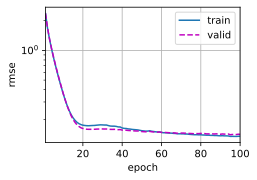

In [22]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 20, 0.03, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs,
                          lr, weight_decay, batch_size)
print(f'{k}-折验证： 平均训练log rmse: {float(train_l):f},'
      f'平均验证log rmse: {float(valid_l):f}')

## 提交Kaggle的预测

In [23]:
def train_and_pred(train_features, train_labels, test_fetures, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train log rmse 0.131710


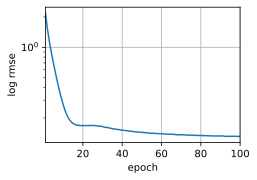

In [24]:
train_and_pred(train_features, train_labels, test_features, test_data,
               num_epochs, lr, weight_decay, batch_size)